# Notebook to query GALEX field and visit information

In [1]:
GALEX_FOV_DIAM = 1.0
exp_mean_min = 800
nr_vis_min = 10 #  >=
surveys =  ["AIS","MIS","DIS","CAI" ,"NGS","GII"] # "AIS",,"CAI" ,"NGS", ,"GII"
fout_name_base = "none"
fout_name_base = "./resources/GALEX_field_id_lists/field_ids_"+''.join(surveys)+"_exp"+str(exp_mean_min)+"_vis"+str(nr_vis_min)  # No file written for "none"

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.table import unique, Table, join, unique
from astropy import units as uu
from astropy.coordinates import SkyCoord
import healpy as hpy
import numpy as np
from vasca.resource_manager import ResourceManager

### Get TDS field info

In [3]:
#Get TDS field info from MAST
#tt_tds = Table.read("./resources/TDS-ApJ_766_60/tds_fields_table2.ecsv")
#dd_query = {"instrument_name":"GALEX",
#             "dataproduct_type":"image",
#             "dataRights":"PUBLIC",
#             "filters":"NUV",
#             "target_name":tt_tds["name"]
#}  
#tt_obs_tds = Observations.query_criteria(**dd_query)
#tt_obs_tds.write("MAST_GALEX_obs_tds.fits")

# Get Tables with field selections to get fields with no FUV detections
#tt_fd_rg = Table.read("~/Code/vasca/vasca/examples/vasca_pipeline/ALL_10-800/region_ALL_10-800.fits", hdu="tt_fields")
#sel_fd_rg = tt_fd_rg["sel"]
#fds= tt_fields_rg["field_id"][~sel_fd_rg].data
#for fd in fds:
#    print(str(fd)[5:-1],",")

#Fields with no fuv detections, even if there is fuv exposure listed in MAST
ll_fuv_nodet = [2524023637061664768 ,2529406845991256064 ,2529477214735433728 ,2529547583479611392 ,2529617952223789056 ,2529758689712144384 ,
                2529899427401826304 ,2529969795944677376, 2530040164688855040 , 2530110533433032704 , 2530180902177210368 , 2531447539572408320 ,
                2531517908316585984 , 2531588277060763648 ,2531658645804941312 , 2538484413990174720 , 2538625151478530048 , 2538695520222707712 ,
                2538906626455240704 , 2540138079478349824 , 2540208448222527488 , 2540278816966705152 ,2540349185912209408 , 2540489923199238144 ,
                2540560291943415808 , 2540771398175948800 , 2540841766920126464 , 2540982504408481792 ,2549602675570245632, 2493237311618154496 ,
                2502314879482855424 ,2504672232547024896 ,2552311872221085696 ,2552910006546595840 ,2552980375290773504 ,3045772690766954496 ,
                3045913428255309824 ,3048798546766594048 ,3049572602952548352 ,3052457721463832576 ,3053689174486941696 ,3054392861928718336 ,
                3058122405370134528 ,3058192774114312192 ,3059037199044444160 ,3059107567788621824 ,3059142752160710656 ,3059177936532799488 ,
                3059740886486220800 ,3061077892625596416 ,3072723919786999808 ,3083736628250804224 ,3123424599967006720 ,]
#Load pre-queried file
tt_obs_tds = Table.read("./resources/TDS-ApJ_766_60/MAST_GALEX_obs_tds.fits")
display(tt_obs_tds[:2] )

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
bytes7,bytes5,bytes3,bytes5,bytes3,bytes3,bytes2,bytes16,bytes1,bytes19,float64,float64,bytes5,bytes1,int64,float64,float64,float64,float64,float64,bytes1,float64,bytes1,bytes3,int64,bytes43,bytes130,bytes124,bytes6,bool,float64,bytes4,bytes4
science,GALEX,DIS,GALEX,DIS,NUV,UV,PS_XMMLSS_MOS00,--,2592597978464124928,35.578863351058885,-3.14176421214975,image,--,2,54791.262777777774,55512.31023148148,40457.25,169300000000.0,300700000000.0,--,55953.94460633,--,DIS,--,CIRCLE ICRS 35.57886335 -3.14176421 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS00-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08150-PS_XMMLSS_MOS00/d/01-main/0007-img/07-try/PS_XMMLSS_MOS00-nd-exp.fits.gz,PUBLIC,True,5885.0,2047,3659
science,GALEX,DIS,GALEX,DIS,NUV,UV,PS_XMMLSS_MOS01,--,2592668347208302592,36.49984981667359,-3.4923125504146,image,--,2,54791.33122685185,55512.37857638889,38609.0,169300000000.0,300700000000.0,--,55953.94680547,--,DIS,--,CIRCLE ICRS 36.49984982 -3.49231255 0.625,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/qa/PS_XMMLSS_MOS01-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/01-vsn/08152-PS_XMMLSS_MOS01/d/01-main/0007-img/07-try/PS_XMMLSS_MOS01-nd-exp.fits.gz,PUBLIC,True,5885.0,2048,3661


### Get all-sky visit and field information

In [4]:
# Get visit table
rm = ResourceManager()
tt_vis = Table.read(rm.get_path("gal_visits_list", "sas_cloud"))

#Show exposure for different surveys
surveys_all =  ["AIS","MIS","DIS","NGS","GII","CAI"] 
for sur in surveys_all:
    csel = (tt_vis['survey']==sur)
    exp_sum = tt_vis[csel]['nexptime'].sum()
    print(sur,": Visits =",csel.sum(),",exposure =",int(exp_sum),"s ,exposure per visit =",int(exp_sum/csel.sum()),"s")
    
#Show TDS info
tt_vis.add_index('ParentImgRunID')
tds_idx = tt_vis.loc_indices[np.array(tt_obs_tds["obs_id"],dtype=np.int64)]
#display(tt_vis[tds_idx ][0:2])
tds_nr_flds = len(unique(tt_vis[tds_idx ], keys='ParentImgRunID'))
tds_exp = tt_vis[tds_idx]['nexptime'].sum()
tds_nr_vis = len(tds_idx)

#Fields with zero FUV events, but FUV exposure>0 listen in database. Set fuv exposure to zero
idx_fuv_nodet = tt_vis.loc_indices[np.array(ll_fuv_nodet,dtype=np.int64)]
tt_vis["fexptime"][idx_fuv_nodet]=0.0

#Select visits
sel_vis = tt_vis["nuv_phot_rate"]<25
print(f"Visits total: {len(tt_vis)} , selected: {sel_vis.sum()}")
tt_vis = tt_vis[sel_vis]

#Generate field info table
tt_vis_uni = unique(tt_vis, keys='ParentImgRunID')
tt_vis_uni_grp = tt_vis_uni.group_by(['ParentImgRunID'])
tt_vis_grp = tt_vis.group_by(['ParentImgRunID'])
tt_vis_mean = tt_vis_grp['ParentImgRunID',"RATileCenter","DECTileCenter","nexptime","fexptime","gall","galb","nuv_phot_rate","nPhotoObjects"].groups.aggregate(np.mean)
tt_vis_sum = tt_vis_grp['ParentImgRunID',"nexptime","fexptime","nPhotoVisits"].groups.aggregate(np.sum)
tt_fd = join(tt_vis_mean, tt_vis_sum, keys='ParentImgRunID',table_names=['mean', 'sum'],uniq_col_name='{col_name}_{table_name}')
tt_fd = join(tt_fd, tt_vis_uni_grp['ParentImgRunID',"survey","minPhotoObsDate","maxPhotoObsDate"], keys='ParentImgRunID')
print("\nCombined field table:")
display(tt_fd[tt_fd["nPhotoVisits"]>1])

print("TDS : Fields =",tds_nr_flds,"Visits =",tds_nr_vis,",exposure =",int(tds_exp),"s ,exposure per visit =",int(tds_exp/tds_nr_vis),"s (part of DIS)")     

AIS : Visits = 64091 ,exposure = 6472340 s ,exposure per visit = 100 s
MIS : Visits = 11125 ,exposure = 12199096 s ,exposure per visit = 1096 s
DIS : Visits = 9763 ,exposure = 9791687 s ,exposure per visit = 1002 s
NGS : Visits = 2446 ,exposure = 2793492 s ,exposure per visit = 1142 s
GII : Visits = 7058 ,exposure = 7944605 s ,exposure per visit = 1125 s
CAI : Visits = 6026 ,exposure = 1029497 s ,exposure per visit = 170 s
Visits total: 100509 , selected: 28549

Combined field table:


ParentImgRunID,RATileCenter,DECTileCenter,nexptime_mean,fexptime_mean,gall,galb,nuv_phot_rate,nPhotoObjects,nexptime_sum,fexptime_sum,nPhotoVisits,survey,minPhotoObsDate,maxPhotoObsDate
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes22,bytes22
2411539199493668864,147.0661637032415,-0.504841940754146,1163.5,1163.5,237.37221641899384,38.061087862771245,5.7927270755747,6688.0,2327.0,2327.0,2,MIS,2/25/2007 5:39:18 AM,2/25/2007 5:56:33 AM
2411574383865757696,146.0403583214765,-0.506040032177233,1235.025,1235.025,236.61854953324604,37.226772860173575,6.27273198513031,7555.5,2470.05,2470.05,2,MIS,2/25/2007 12:43:31 AM,2/25/2007 1:08:16 AM
2411644752609935360,147.0810945792465,1.182294399384555,1178.05,1178.05,235.62319547876172,39.04906619362759,5.93517434123952,6355.0,2356.1,2356.1,2,MIS,2/25/2007 8:56:29 AM,2/25/2007 9:23:32 AM
2411679936982024192,148.611148096335,0.338697901824151,958.55,958.55,237.6612029964329,39.80693074183459,9.78938029951599,9255.0,1917.1,1917.1,2,MIS,2/26/2007 4:39:37 AM,2/26/2007 4:53:38 AM
2411715121354113024,147.58607508049153,0.33379393925884804,1016.0749999999999,1016.0749999999999,236.89012736487246,38.97286832587748,7.306507958817999,7311.5,2032.1499999999999,2032.1499999999999,2,MIS,3/19/2004 1:51:06 AM,3/19/2004 2:05:32 AM
2411750305726201856,149.1221554520945,-0.5149753319001735,1520.575,1520.575,238.94932777174495,39.71037530711409,6.652563687270486,10087.0,3041.15,3041.15,2,MIS,2/26/2007 7:56:48 AM,2/26/2007 8:20:13 AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443070106548305920,323.0378229721924,0.24348170667659755,301.3134615384616,301.2365384615385,54.23741944053312,-34.90715638433906,21.84596616612799,6574.7692307692305,7834.150000000001,7832.150000000001,26,CAI,7/28/2007 9:33:13 PM,7/28/2007 9:38:08 PM
6443140475292483584,322.9872638199539,0.21553867998728013,291.64071428571424,291.64071428571424,54.17471877437209,-34.88077105871114,21.802107397133852,6351.814285714286,20414.85,20414.85,70,CAI,7/18/2008 1:11:46 PM,7/18/2008 1:16:31 PM


TDS : Fields = 42 Visits = 1201 ,exposure = 1616734 s ,exposure per visit = 1346 s (part of DIS)


### Define field selections and compare available data-set to TDS 
ULTRASAT sensitity is 22.4 ABmag at 5 sigma in 900s over 170 deg2
GALEX NUV sensitivity in 1500s is 22.7 ABmag https://ui.adsabs.harvard.edu/abs/2005ApJ...619L...7M/abstract

In [5]:
#Select fields
sel_fd_nexptime = tt_fd["nexptime_mean"]>exp_mean_min
sel_fd_nPhotoVisits = tt_fd["nPhotoVisits"]>nr_vis_min -0.5
sel_sur = sel_fd_nexptime*0
for sur in surveys:
    sel_sur += (tt_fd["survey"]== sur)
sel_sur = np.array(sel_sur,dtype=bool)
sel_fd = sel_fd_nexptime*sel_fd_nPhotoVisits*sel_sur
print(sel_fd.sum(),sel_fd_nexptime.sum(),sel_fd_nPhotoVisits.sum(),sel_sur.sum())
display(tt_fd[sel_fd][0:2])

#Print out basic info
#sel_fd_area = sel_fd.sum() * 3.1415*(GALEX_FOV_DIAM/2.)**2
fd_nuv_exp = (tt_fd[sel_fd]["nPhotoVisits"]*tt_fd[sel_fd]["nexptime_mean"]).sum()
fd_fuv_exp = (tt_fd[sel_fd]["nPhotoVisits"]*tt_fd[sel_fd]["fexptime_mean"]).sum()
fov_area = 3.1416*(GALEX_FOV_DIAM/2)**2 
print(f"Selected number of fields: {sel_fd.sum()} ( {round(sel_fd.sum()/tds_nr_flds,2)} times TDS, ~{sel_fd.sum()*fov_area} deg2)")
print(f"Selected number of visits: {tt_fd[sel_fd]['nPhotoVisits'].sum()} ( {round(tt_fd[sel_fd]['nPhotoVisits'].sum()/tds_nr_vis,2)} times TDS, {round(tt_fd[sel_fd]['nPhotoVisits'].sum()/sel_fd.sum(),2)} per field)")
print(f"Total selected NUV exposure  : {round(fd_nuv_exp/1e6,2)} Ms ( {round(fd_nuv_exp/tt_fd[sel_fd]['nPhotoVisits'].sum(),2)} s average, {round(fd_nuv_exp/tds_exp,2)} times TDS ), FUV exposure is {round(fd_fuv_exp/1e6,2)} Ms \n")
#display(tt_fd[sel_fd])

#Show exposure for different surveys
for sur in surveys:
    fsel = (tt_fd[sel_fd]['survey']==sur)
    nvis =  tt_fd[sel_fd][fsel]['nPhotoVisits'].sum()
    exp_sum = tt_fd[sel_fd][fsel]['nexptime_sum'].sum()
    print(sur,": Visits =",nvis,",exposure =",int(exp_sum),"s ,exposure per visit =",exp_sum/nvis,"s")

382 8566 412 10618


ParentImgRunID,RATileCenter,DECTileCenter,nexptime_mean,fexptime_mean,gall,galb,nuv_phot_rate,nPhotoObjects,nexptime_sum,fexptime_sum,nPhotoVisits,survey,minPhotoObsDate,maxPhotoObsDate
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes22,bytes22
2482083865531777024,11.8910606122809,-25.283705129307165,1367.5181818181818,298.2863636363636,97.4942074076784,-87.96105753853617,8.416246655156435,9785.09090909091,15042.699999999999,3281.1499999999996,11,NGS,10/13/2003 7:40:26 AM,10/13/2003 8:07:46 AM
2485602302774214656,141.58655039683708,-76.62359690914174,1147.625,1147.5416666666667,291.9703987440094,-18.348898831918717,7.370263428863324,6982.166666666667,13771.5,13770.5,12,NGS,4/1/2004 10:23:20 AM,4/1/2004 10:50:48 AM


Selected number of fields: 382 ( 9.1 times TDS, ~300.0228 deg2)
Selected number of visits: 9947 ( 8.28 times TDS, 26.04 per field)
Total selected NUV exposure  : 12.46 Ms ( 1253.08 s average, 7.71 times TDS ), FUV exposure is 5.95 Ms 

AIS : Visits = 0 ,exposure = 0 s ,exposure per visit = nan s
MIS : Visits = 37 ,exposure = 34434 s ,exposure per visit = 930.6675675675675 s
DIS : Visits = 6544 ,exposure = 8450470 s ,exposure per visit = 1291.331020782396 s
CAI : Visits = 85 ,exposure = 100804 s ,exposure per visit = 1185.938823529412 s
NGS : Visits = 930 ,exposure = 1156796 s ,exposure per visit = 1243.8670967741934 s
GII : Visits = 2351 ,exposure = 2721924 s ,exposure per visit = 1157.7732241599317 s


/tmp/ipykernel_15673/2573303810.py:27: RuntimeWarning: invalid value encountered in scalar divide
  print(sur,": Visits =",nvis,",exposure =",int(exp_sum),"s ,exposure per visit =",exp_sum/nvis,"s")


In [6]:
display(tt_fd)
display(tt_vis)

ParentImgRunID,RATileCenter,DECTileCenter,nexptime_mean,fexptime_mean,gall,galb,nuv_phot_rate,nPhotoObjects,nexptime_sum,fexptime_sum,nPhotoVisits,survey,minPhotoObsDate,maxPhotoObsDate
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,bytes22,bytes22
2391589660720627712,210.542232477159,-32.6804067553693,544.0,544.0,319.74270865062874,27.871918173555255,14.303308823529411,7781.0,544.0,544.0,1,NGS,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM
2391624845092716544,201.528614022379,-42.9957260941383,937.0,937.0,309.64494588030084,19.423571577159674,8.813233724653148,8258.0,937.0,937.0,1,NGS,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM
2391660029464805376,203.769181415483,-30.085639855328,1349.05,1349.05,314.0467834685246,31.84251982355922,7.64241503280086,10310.0,1349.05,1349.05,1,NGS,6/7/2003 8:19:41 AM,6/7/2003 8:42:10 AM
2391730398208983040,231.921642929177,3.34027063665351,1696.0,1696.0,7.318115437067729,45.76107027896758,7.034787735849057,11931.0,1696.0,1696.0,1,MIS,6/7/2003 11:37:03 AM,6/7/2003 12:05:19 PM
2391765582581071872,231.294710460205,2.47871950720032,1698.45,1698.45,5.791997165545202,45.74212396120733,7.188907533339221,12210.0,1698.45,1698.45,1,MIS,6/7/2003 1:15:37 PM,6/7/2003 1:43:55 PM
2391800766953160704,230.830932461494,3.23716734012699,1700.05,1700.05,6.256101183947215,46.57064854646065,7.100967618599453,12072.0,1700.05,1700.05,1,MIS,6/7/2003 2:54:16 PM,6/7/2003 3:22:36 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6486135777985036288,51.5719829555028,-7.06351337919992,1341.05,0.0,191.49807301731585,-48.18090431531411,6.188434435703367,8299.0,1341.05,0.0,1,CAI,11/1/2009 4:30:59 PM,11/1/2009 4:53:20 PM
6486170962357125120,318.28898434295,-6.6829868262018,1047.15,1047.15,44.04474806595707,-34.436099523580815,7.845103375829632,8215.0,1047.15,1047.15,1,CAI,7/22/2008 7:33:19 AM,7/22/2008 7:50:46 AM


RATileCenter,DECTileCenter,survey,nexptime,fexptime,imgRunID,ParentImgRunID,joinID,tileNum,specTileNum,source,nPhotoObjects,nPhotoVisits,PhotoObsDate,spectra,nSpectra,nSpectraVisits,SpecObsDate,visitNum,subvis,minPhotoObsDate,maxPhotoObsDate,minSpecObsDate,maxSpecObsDate,PhotoObsDate_MJD,gall,galb,vis_id,exp_ratio,minPhotoObsDate_MJD,maxPhotoObsDate_MJD,delta_time_phot,nuv_tphot_frac,nuv_phot_rate
float64,float64,bytes3,float64,float64,int64,int64,int64,int64,int64,bytes6,int64,int64,bytes22,bytes5,bytes4,bytes4,bytes4,int64,int64,bytes22,bytes22,bytes4,bytes4,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
210.542232477159,-32.6804067553693,NGS,544.0,544.0,2391589523080347648,2391589660720627712,7804,2437,-999,visitI,7781,1,6/7/2003 5:02:29 AM,False,null,null,null,1,-999,6/7/2003 5:02:29 AM,6/7/2003 5:11:33 AM,null,null,52797.21005787037,319.74270865062874,27.871918173555255,2391589523080347648,1.0,52797.21005787037,52797.21635416667,544.0000001806766,1.000000000332126,14.303308823529411
201.528614022379,-42.9957260941383,NGS,937.0,937.0,2391624707452436480,2391624845092716544,74460,2438,-999,visitI,8258,1,6/7/2003 6:41:02 AM,False,null,null,null,1,-999,6/7/2003 6:41:02 AM,6/7/2003 6:56:39 AM,null,null,52797.278495370374,309.64494588030084,19.423571577159674,2391624707452436480,1.0,52797.278495370374,52797.28934027778,936.9999996386468,0.9999999996143509,8.813233724653148
203.769181415483,-30.085639855328,NGS,1349.05,1349.05,2391659891824525312,2391660029464805376,55314,2439,-999,visitI,10310,1,6/7/2003 8:19:41 AM,False,null,null,null,1,-999,6/7/2003 8:19:41 AM,6/7/2003 8:42:10 AM,null,null,52797.34700231482,314.0467834685246,31.84251982355922,2391659891824525312,1.0,52797.34700231482,52797.36261574074,1348.999999766238,0.9999629367082303,7.64241503280086
231.921642929177,3.34027063665351,MIS,1696.0,1696.0,2391730260568702976,2391730398208983040,60377,2441,-999,visitI,11931,1,6/7/2003 11:37:03 AM,False,null,null,null,1,-999,6/7/2003 11:37:03 AM,6/7/2003 12:05:19 PM,null,null,52797.4840625,7.318115437067729,45.76107027896758,2391730260568702976,1.0,52797.4840625,52797.50369212963,1695.9999997867271,0.9999999998742495,7.034787735849057
231.294710460205,2.47871950720032,MIS,1698.45,1698.45,2391765444940791808,2391765582581071872,80501,2442,-999,visitI,12210,1,6/7/2003 1:15:37 PM,False,null,null,null,1,-999,6/7/2003 1:15:37 PM,6/7/2003 1:43:55 PM,null,null,52797.552511574075,5.791997165545202,45.74212396120733,2391765444940791808,1.0,52797.552511574075,52797.572164351855,1698.000000254251,0.9997350526976072,7.188907533339221
230.830932461494,3.23716734012699,MIS,1700.05,1700.05,2391800629312880640,2391800766953160704,19263,2443,-999,visitI,12072,1,6/7/2003 2:54:16 PM,False,null,null,null,1,-999,6/7/2003 2:54:16 PM,6/7/2003 3:22:36 PM,null,null,52797.62101851852,6.256101183947215,46.57064854646065,2391800629312880640,1.0,52797.62101851852,52797.640694444446,1700.0000000931323,0.9999705891551027,7.100967618599453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57.0123625434868,17.1333305517839,MIS,1614.2,0.0,4576363107911204864,4576363245576650752,64109,64532,-999,visitI,5365,1,12/22/2011 8:09:11 PM,False,null,null,null,1,-999,12/22/2011 8:09:11 PM,12/22/2011 8:36:05 PM,null,null,55917.83971064815,172.11985424568047,-28.41685586315213,4576363107911204864,0.0,55917.83971064815,55917.85839120371,1614.0000001061708,0.9998760996816818,3.32362780324619
56.9904000192869,17.1432695845655,MIS,1064.1,0.0,4576363107944759296,4576363245576650752,62033,64532,-999,visitI,5063,1,12/23/2011 1:14:06 AM,False,null,null,null,2,-999,12/23/2011 1:14:06 AM,12/23/2011 1:31:50 AM,null,null,55918.051458333335,172.09495992419585,-28.42459572467484,4576363107944759296,0.0,55918.051458333335,55918.06377314815,1063.9999997802079,0.999906023663385,4.758011465087868


### Write out field_id file

In [7]:
if fout_name_base != "none":
    ff_nuv = open(fout_name_base+"_nuv.yaml", "w")
    ff_fuv = open(fout_name_base+"_fuv.yaml", "w")
    ll_cols = ['RATileCenter', 'DECTileCenter', 'nexptime_sum', 'fexptime_sum', 'nPhotoVisits', 'survey']
    wstr = "#"
    for col in ll_cols: wstr += " " + str(col) 
    ff_nuv.write(wstr+"\n")
    ff_fuv.write(wstr+"\n")
    for row in tt_fd[sel_fd]:
        wstr = '- '+ str(row["ParentImgRunID"]) + " #"
        for col in ll_cols:  wstr += " " + str(row[col])
        if row["nexptime_sum"]>1e-9:
            ff_nuv.write(wstr+"\n")
        if row["fexptime_sum"]>1e-9:
            ff_fuv.write(wstr+"\n")
    ff_nuv.close()
    ff_fuv.close()

### Plot some field distributions

Text(0.5, 0, 'Mean exposure time[s]')

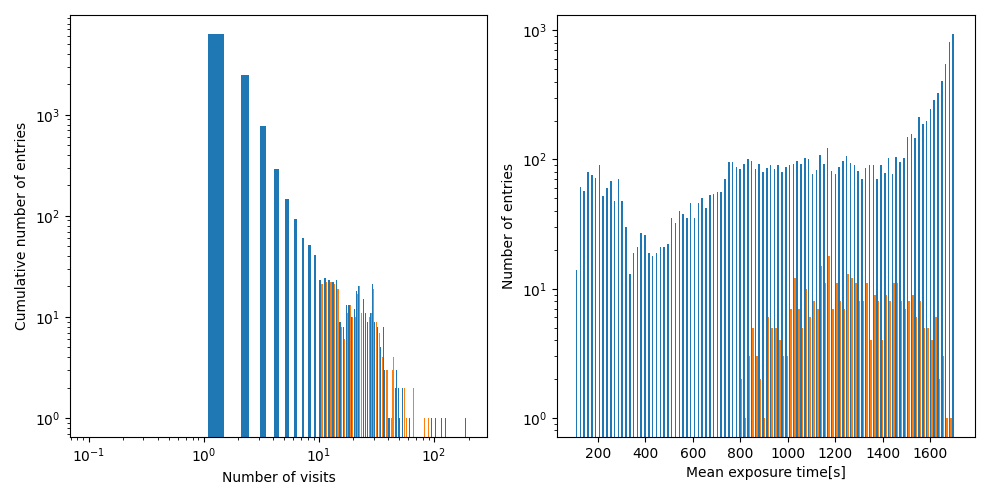

In [8]:
# Plot some field property distributions
fig, axs = plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
hist = axs[0].hist([tt_fd["nPhotoVisits"],tt_fd[sel_fd]["nPhotoVisits"]], bins= range(0,200)) #,cumulative=-1
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_ylabel("Cumulative number of entries")
axs[0].set_xlabel("Number of visits")
hist = axs[1].hist([tt_fd["nexptime_mean"],tt_fd[sel_fd]["nexptime_mean"]], bins= 100)
axs[1].set_yscale("log")
axs[1].set_ylabel("Number of entries")
axs[1].set_xlabel("Mean exposure time[s]")

### Plot coverage on the sky

High resolution pixel diameter: 0.0143 deg Npix: 201326592 Nside: 4096


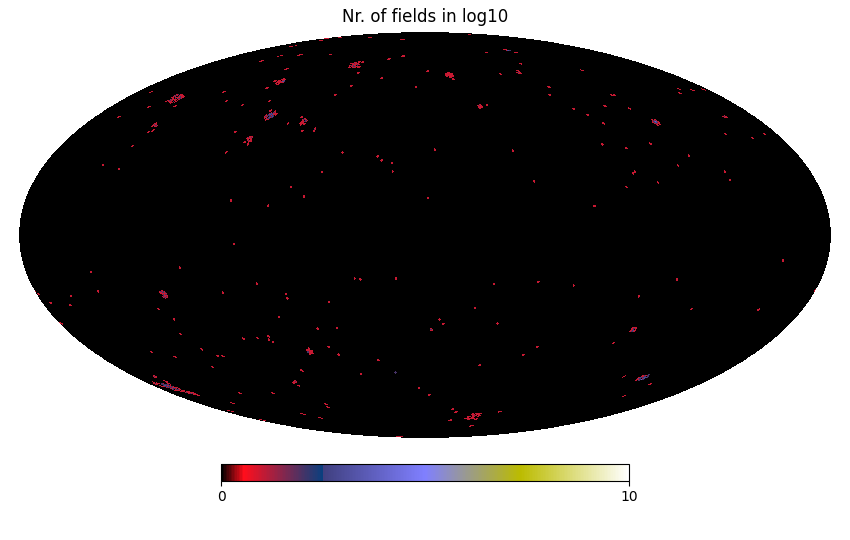

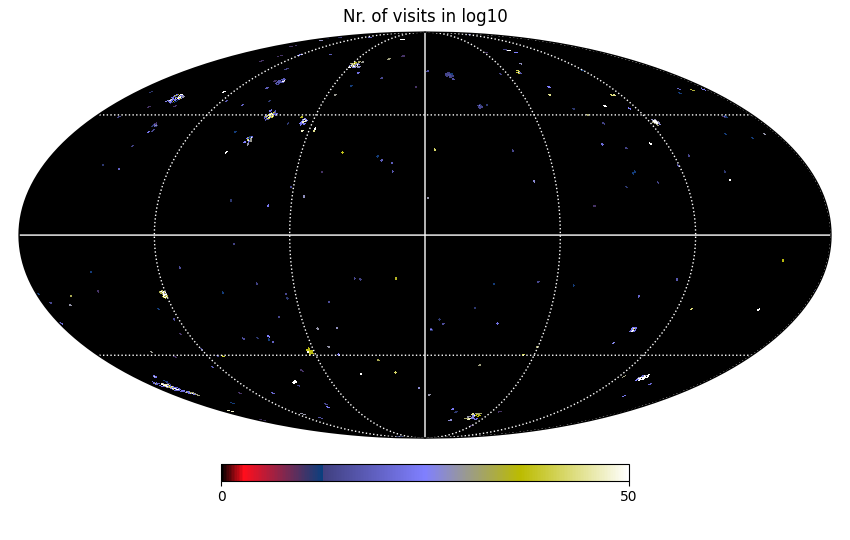

In [9]:
#Add healpix info
cosys     = "G" #"Q" for equatorial, "G" for galactic
nside     = 256
npix      = hpy.nside2npix(nside)
tt_vis["hpix"] = hpy.ang2pix(nside,tt_vis["gall"],tt_vis["galb"],lonlat=True,nest=False)

plot_sky = True
if plot_sky:
    #Setup high res plotting data
    nside_hres     = nside*16
    npix_hres = hpy.nside2npix(nside_hres)
    pix_diam_hres = hpy.nside2resol(nside_hres, arcmin=True) / 60 * uu.deg
    print("High resolution pixel diameter:",np.round(pix_diam_hres,4),"Npix:",npix_hres,"Nside:",nside_hres)
    tt_fd["hvec"] = hpy.ang2vec(tt_fd["gall"],tt_fd["galb"],lonlat=True)

    nr_vis_hres = np.zeros(npix_hres)  # empty map
    nr_fd_hres = np.zeros(npix_hres)  # empty map

    # fill map with coverage data
    for fd in tt_fd[sel_fd]:
        ipix_disc = hpy.query_disc(nside=nside_hres, vec=fd["hvec"], radius=np.radians(GALEX_FOV_DIAM/2.))
        nr_fd_hres[ipix_disc] += 1  # number of fields
        nr_vis_hres[ipix_disc] += fd["nPhotoVisits"]

    #Plot
    hpy.mollview(nr_fd_hres, title="Nr. of fields in log10",nest=False,cmap="gist_stern",min=0,max=10,xsize=4800)
    hpy.mollview(nr_vis_hres, title="Nr. of visits in log10",nest=False,cmap="gist_stern",min=0,max=50, xsize=4800)
    hpy.graticule(color="white",dpar=45, dmer=60)

#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)